# Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling

**Resources:**
- LDA:
    - https://medium.com/sayahfares19/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06 
    - https://www.kaggle.com/code/faressayah/text-analysis-topic-modeling-with-spacy-gensim#%F0%9F%93%9A-Topic-Modeling (code for previous post)
    - https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf/ 
- BERTopic:
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_documents.html#visualize-documents-with-plotly 
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_topics.html 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import spacy
from spacy import displacy
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import pyLDAvis
import pyLDAvis.gensim_models
plt.style.use('seaborn-v0_8-dark')
sou = pd.read_csv("data/SOTU.csv")
nlp = spacy.load("en_core_web_sm")
sou.head()

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169


### LDA

- Train an LDA model with 18 topics
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization

You may use the next two cells to process the data.

In [4]:
def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]

In [5]:
# Process all texts - note this takes ~ 5 minutes to run
processed_docs = sou['Text'].apply(preprocess_text)

In [6]:
processed_docs.head()

0    [speak, president, present, prepared, remark, ...
1    [president, speaker, point, president, turn, f...
2    [president, thank, thank, thank, madam, speake...
3    [president, thank, thank, thank, good, mitch, ...
4    [president, thank, thank, thank, madam, speake...
Name: Text, dtype: object

To train an LDA model, use the LdaModel function that we imported a couple of cells back. The last resource linked under the LDA section is especially useful for walking through the steps we have below. *Note: one of the arguments to the LdaModel function is `random_state` which specifies the random seed for reproducibility. Please set yours to 42. Further, the last resource provided uses `LdaMulticore` which is essentially a parallelizable version of our function `LdaModel`. Use `LdaModel` instead, but the usage will be similar, except you can ignore the `iterations` and `workers` arguments..*.

In [7]:
# Build dictionary from processed_docs, which is a list of tokens extracted from our speeches
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [8]:
# train LDA model with 18 topics
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=18,
    random_state=42,
    passes=10,
    alpha="auto",
    eta="auto",
)

In [9]:
# print the top 10 words for each topic

print("--- LDA Topics ---")
for topic_id in range(lda_model.num_topics):
    terms = lda_model.show_topic(topic_id, topn=10)
    terms_str = " + ".join([f'{weight:.3f}*"{word}"' for word, weight in terms])
    print(f"Topic: {topic_id} \nWords: {terms_str}\n")

--- LDA Topics ---
Topic: 0 
Words: 0.013*"states" + 0.013*"government" + 0.009*"united" + 0.008*"congress" + 0.007*"country" + 0.006*"year" + 0.006*"public" + 0.006*"great" + 0.005*"state" + 0.005*"power"

Topic: 1 
Words: 0.002*"year" + 0.002*"people" + 0.002*"government" + 0.001*"states" + 0.001*"congress" + 0.001*"country" + 0.001*"nation" + 0.001*"great" + 0.001*"time" + 0.001*"united"

Topic: 2 
Words: 0.003*"year" + 0.003*"government" + 0.002*"states" + 0.002*"congress" + 0.002*"united" + 0.002*"people" + 0.002*"great" + 0.002*"service" + 0.002*"public" + 0.001*"increase"

Topic: 3 
Words: 0.015*"year" + 0.011*"world" + 0.011*"people" + 0.011*"america" + 0.010*"nation" + 0.007*"help" + 0.007*"congress" + 0.007*"american" + 0.007*"work" + 0.006*"time"

Topic: 4 
Words: 0.008*"isthmus" + 0.006*"colombia" + 0.005*"government" + 0.004*"states" + 0.004*"panama" + 0.004*"united" + 0.004*"colombian" + 0.004*"treaty" + 0.003*"year" + 0.003*"congress"

Topic: 5 
Words: 0.003*"year" + 0.0

In [10]:
# print the topic distribution for the first speech
import numpy as np

first_doc_bow = corpus[0]
topic_dist_first = lda_model[first_doc_bow]

topic_dist_first_sorted = sorted(topic_dist_first, key=lambda x: -x[1])
topic_dist_first_sorted

[(7, np.float32(0.99979365))]

In [14]:
# make a visualization using pyLDAvis
pyLDAvis.enable_notebook()

lda_vis_data = pyLDAvis.gensim_models.prepare(
    lda_model,
    corpus,
    dictionary,
    sort_topics=False
)

pyLDAvis.save_html(lda_vis_data, "outputs/lda_topics.html")

lda_vis_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.162407  0.126359       1        1  35.462886
1     -0.128391 -0.030213       2        1   0.000706
2     -0.057232 -0.009091       3        1   0.000754
3      0.202767 -0.134174       4        1  12.638431
4     -0.041443  0.041433       5        1   0.023970
5     -0.114964 -0.007566       6        1   0.000723
6      0.157218  0.060462       7        1  25.777263
7      0.167979 -0.166570       8        1   7.051188
8      0.155620  0.155780       9        1   5.076636
9     -0.058771  0.027320      10        1   0.025938
10     0.178883 -0.028805      11        1  13.736458
11    -0.125766  0.003805      12        1   0.000723
12    -0.061196  0.032968      13        1   0.004708
13    -0.090961 -0.005333      14        1   0.000731
14    -0.156912 -0.020532      15        1   0.000669
15    -0.136545 -0.010653      16        1   0.000682
16     0.000763 -0.007815      17        1   0.168876
17    -0.053457 -0.027376      18        1   0.028657, topic_info=            Term         Freq        Total Category  logprob  loglift
1525  government  8291.000000  8291.000000  Default  30.0000  30.0000
1066      states  6521.000000  6521.000000  Default  29.0000  29.0000
1250        year  7008.000000  7008.000000  Default  28.0000  28.0000
223     congress  5397.000000  5397.000000  Default  27.0000  27.0000
1185      united  5055.000000  5055.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
52      american     0.412869  3052.380762  Topic18  -6.3338  -0.7508
1136        time     0.405259  3607.877787  Topic18  -6.3524  -0.9366
50       america     0.371549  2139.571177  Topic18  -6.4393  -0.5009
1580    interest     0.338749  2704.599028  Topic18  -6.5317  -0.8277
335         duty     0.322331  2108.842656  Topic18  -6.5814  -0.6286

[1383 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
9256      4  0.982183  --to
9084      4  0.984320  --we
9111      1  0.813815  1791
9111      4  0.101727  1791
9111      9  0.101727  1791
...     ...       ...   ...
1250      8  0.100314  year
1250      9  0.027112  year
1250     11  0.154252  year
1250     17  0.000571  year
1250     18  0.000143  year

[2013 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

### BERTopic

- Train a BERTopic model with a `min_topic_size` of 3 *Hint: use `BERTopic` to instantiate the model and specify `min_topic_size` in here. Actually fit the model using `fit_transform`, which `docs` passed into this.*
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization of the topics (see topic_model.visualize_topics())

In [15]:
docs = sou['Text'].to_list()

In [16]:
# train the model - this takes about 30 seconds
topic_model = BERTopic(
    min_topic_size=3,
    verbose=True,
)

topics, probs = topic_model.fit_transform(docs)

# remove stop words from the topics (Hint: use CountVectorizer and then .update_topics on topic_model)
vectorizer_model = CountVectorizer(stop_words="english")
topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

2025-11-21 23:49:58,083 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:09<00:00,  1.17s/it]
2025-11-21 23:50:09,975 - BERTopic - Embedding - Completed ✓
2025-11-21 23:50:09,976 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-21 23:50:19,872 - BERTopic - Dimensionality - Completed ✓
2025-11-21 23:50:19,873 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-21 23:50:19,886 - BERTopic - Cluster - Completed ✓
2025-11-21 23:50:19,891 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-21 23:50:21,343 - BERTopic - Representation - Completed ✓


In [17]:
# output the top 10 words for each topic - hint see get_topic_info
topic_info = topic_model.get_topic_info()
topic_info.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,38,-1_states_government_united_congress,"[states, government, united, congress, year, p...",[\nFellow Citizens of the Senate and of the Ho...
1,0,86,0_america_world_new_people,"[america, world, new, people, american, years,...","[\nMr. President, Mr. Speaker, Members of the ..."
2,1,24,1_states_united_government_public,"[states, united, government, public, congress,...",[\nFellow-Citizens of the Senate and House of ...
3,2,20,2_government_congress_public_national,"[government, congress, public, national, great...",[\nTo the Senate and House of Representatives:...
4,3,14,3_government_states_public_united,"[government, states, public, united, congress,...",[\nFellow Citizens of the Senate and of the Ho...
5,4,13,4_government_states_united_year,"[government, states, united, year, congress, l...",[\nTo the Senate and House of Representatives:...
6,5,12,5_government_states_united_public,"[government, states, united, public, congress,...",[\nFellow-Citizens of the Senate and House of ...
7,6,8,6_states_government_united_constitution,"[states, government, united, constitution, con...",[\nFellow-Citizens of the Senate and House of ...
8,7,5,7_bank_states_public_government,"[bank, states, public, government, country, ne...",[\nFellow-Citizens of the Senate and House of ...
9,8,5,8_government_shall_congress_world,"[government, shall, congress, world, people, m...",[\n[Delivered in person before a joint session...


100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


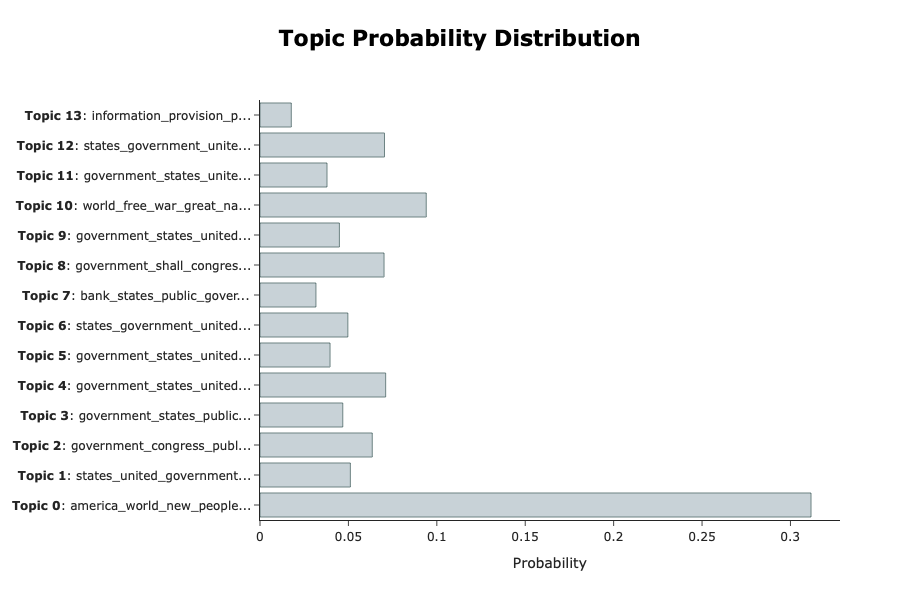

In [18]:
# output the topic distribution for the first speech
# hint: check out approximate_distribution() and visualize_distribution()
first_doc = [docs[0]]

topic_probs, _ = topic_model.approximate_distribution(first_doc)
fig = topic_model.visualize_distribution(topic_probs[0])

fig.write_html("outputs/bertopic_first_speech_distribution.html")

fig

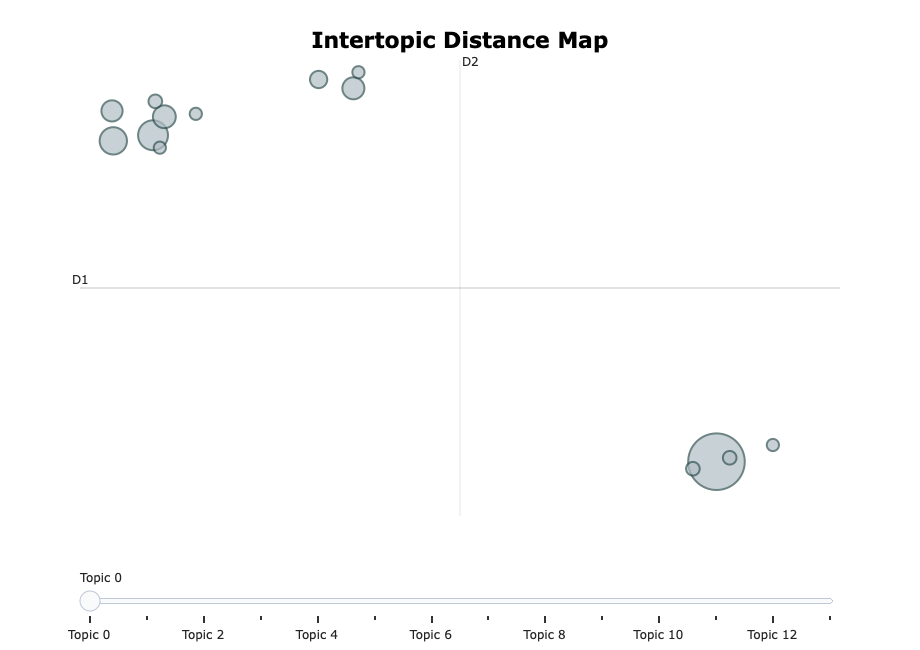

In [19]:
# run this cell to visualize the topics
fig_topics = topic_model.visualize_topics()

fig_topics.write_html("outputs/bertopic_topics.html")

fig_topics